In [ ]:
!wget --header="Host: doc-0o-7c-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_gbsevnc13krov7rjgq2cj0s062jqolpo_nonce=is9fki15n9l7g" --header="Connection: keep-alive" "https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ths62md7879q0rdb5g663rm4c96q2241/275lqhn22n64n8ake3kdd2q74e0favrl/1634604525000/00484516897554883881/06568700698331676125/1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_?e=download&authuser=0&nonce=is9fki15n9l7g&user=06568700698331676125&hash=ogpsn2sqv9k9c8a2hbfdbnmpqgi1kncs" -c -O 'glove_vectors'

--2021-10-19 00:49:19--  https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ths62md7879q0rdb5g663rm4c96q2241/275lqhn22n64n8ake3kdd2q74e0favrl/1634604525000/00484516897554883881/06568700698331676125/1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_?e=download&authuser=0&nonce=is9fki15n9l7g&user=06568700698331676125&hash=ogpsn2sqv9k9c8a2hbfdbnmpqgi1kncs
Resolving doc-0o-7c-docs.googleusercontent.com (doc-0o-7c-docs.googleusercontent.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to doc-0o-7c-docs.googleusercontent.com (doc-0o-7c-docs.googleusercontent.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127506004 (122M) [application/octet-stream]
Saving to: ‘glove_vectors’

glove_vectors       100%[===================>] 121.60M   114MB/s    in 1.1s    

2021-10-19 00:49:21 (114 MB/s) - ‘glove_vectors’ saved [127506004/127506004]



Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import zeros
import pickle
import scipy
import os
import datetime
from scipy.stats import randint as sp_randint
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics  import f1_score,roc_auc_score
import warnings
import nltk
nltk.download('vader_lexicon')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Input, Flatten,Dropout,Conv1D,Concatenate
from tensorflow.keras.layers import BatchNormalization,Embedding,Bidirectional,LSTM

In [ ]:
#read train and validation data
train_data=pd.read_csv('/content/drive/MyDrive/Meme/data/train_data.csv')
validation_data=pd.read_csv("/content/drive/MyDrive/Meme/data/validation_data.csv")
test_data=pd.read_csv('/content/drive/MyDrive/Meme/data/test_data.csv')

In [ ]:
#fill thumbnail.width missing values
mean_width=train_data['thumbnail.width'].mean()
train_data['thumbnail.width'].fillna(value=mean_width,inplace=True)
validation_data['thumbnail.width'].fillna(value=mean_width,inplace=True)
test_data['thumbnail.width'].fillna(value=mean_width,inplace=True)

# fill  thumbnail.height missing values
mean_height=train_data['thumbnail.height'].mean()
train_data['thumbnail.height'].fillna(value=mean_height,inplace=True)
validation_data['thumbnail.height'].fillna(value=mean_height,inplace=True)
test_data['thumbnail.height'].fillna(value=mean_height,inplace=True)


In [ ]:
#calculate area of image
train_data['area']=train_data['thumbnail.height']*train_data['thumbnail.width']
validation_data['area']=validation_data['thumbnail.height']*validation_data['thumbnail.width']

In [ ]:
#define sentiment scores on text
def sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in data['text'].values: 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

# Train data  sentiment_scores
train_comp,train_neg,train_pos,train_neu=sentiment_scores(train_data)
train_data['com']=train_comp
train_data['neg']=train_neg
train_data['pos']=train_pos
train_data['neu']=train_neu

#validation data sentiment_scores
validation_comp,validation_neg,validation_pos,validation_neu=sentiment_scores(validation_data)
validation_data['com']=validation_comp
validation_data['neg']=validation_neg
validation_data['pos']=validation_pos
validation_data['neu']=validation_neu

# test data sentiment_scores
test_comp,test_neg,test_pos,test_neu=sentiment_scores(test_data)
test_data['com']=test_comp
test_data['neg']=test_neg
test_data['pos']=test_pos
test_data['neu']=test_neu

In [ ]:
print("shape of train_data:",train_data.shape)
print("shape of test_data:",test_data.shape)
print("shape of validation_data:",validation_data.shape)

shape of train_data: (3264, 35)
shape of test_data: (1637, 35)
shape of validation_data: (1615, 35)


In [ ]:
#numeric features for training
list_features=['ocr_no_of_words', 'ocr_text_len', 'ocr_preprocess_no_of_words', 'ocr_preprocess_text_len',
               'title_no_of_words', 'title_len','title_preprocess_no_of_words', 'title_preprocess_text_len',
              'thumbnail.height' , 'thumbnail.width','time_of_day','com', 'neg', 'pos', 'neu']

def min_max_scaling(df,list_features,dict_mm={ }):
    
    result = df.copy()
    if not bool(dict_mm):  #if dict is empty then we are finding mean and max for train data
        for feature_name in list_features:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            dict_mm[feature_name]=[max_value,min_value]
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result,dict_mm   
    else:                    #use train data min and max
        for feature_name in list_features:
            max_value=dict_mm[feature_name][0]
            min_value=dict_mm[feature_name][1]
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result

# min-max scaling on numeric features
train_data,dict_mm=min_max_scaling(train_data,list_features)
test_data=min_max_scaling(test_data,list_features,dict_mm)
validation_data=min_max_scaling(validation_data,list_features,dict_mm)

train_numeric=train_data[list_features]
validation_numeric=validation_data[list_features]
test_numeric=test_data[list_features]

Tokenizer on text

In [ ]:
# prepare tokenizer
v = Tokenizer(filters='#$%&*+-/;<=>?@[\\]^`{|}~\t\n') # remove special characters
v.fit_on_texts(train_data['text'].values)
train_text =v.texts_to_sequences(train_data['text'].values )
validation_text=v.texts_to_sequences(validation_data['text'].values)
test_text=v.texts_to_sequences(test_data['text'].values )

In [ ]:
#number of vocab
vocab_size_text=len(v.word_index)+1
vocab_size_text

5815

In [ ]:
# calculate mean words in sentence
sum=0
for i in train_text:
  sum=sum+len(i)
avg=sum/train_data.shape[0]
print(avg)

11.412377450980392


In [ ]:
max_len_text=20 # max length of word in each sentence
dim_text=300

In [ ]:
#padding
train_text_padded_docs=np.array(pad_sequences(train_text,maxlen=max_len_text,padding='post',  truncating='post' ))
validation_text_padded_docs=np.array(pad_sequences(validation_text,maxlen=max_len_text,padding='post',truncating='post' ))
test_text_padded_docs=np.array(pad_sequences(test_text,maxlen=max_len_text,padding='post',truncating='post'))

In [ ]:
print("sentence after padding looks like:")
train_text_padded_docs[0]

sentence after padding looks like:


array([ 779,  780, 1634,  781,  312,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
import pickle
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#https://drive.google.com/drive/u/0/folders/1CJnItndeSSJu7aragQoXWZS9-0apN6pp
with open('/content/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#prepare embedding matrix
embedding_matrix_text= zeros((vocab_size_text, dim_text))
for word, i in v.word_index.items():
  embedding_vector = model.get(word)
  if embedding_vector is not None:
		 embedding_matrix_text[i] = embedding_vector
print("shape of embedding matrix:",embedding_matrix_text.shape)     

shape of embedding matrix: (5815, 300)


In [ ]:
print("->features in data:")
print("*"*50)
train_data.columns

->features in data:
**************************************************


Index(['id', 'ocr_text', 'ocr_no_of_words', 'ocr_text_len', 'ocr_preprocess',
       'ocr_preprocess_no_of_words', 'ocr_preprocess_text_len', 'index',
       'created_utc', 'downs', 'is_nsfw', 'media', 'subreddit', 'subscribers',
       'thumbnail.height', 'thumbnail.thumbnail', 'thumbnail.width', 'title',
       'ups', 'url', 'datetime_temp', 'time_of_day', 'ups_normed',
       'dank_level', 'title_no_of_words', 'title_len', 'title_preprocess',
       'title_preprocess_no_of_words', 'title_preprocess_text_len', 'path',
       'text', 'com', 'neg', 'pos', 'neu'],
      dtype='object')

In [ ]:
def lstm_model(drop_rate):
  #text
  a_input= tensorflow.keras.layers.Input(shape=(20,),name='text') # dtype="int64"
  embedding_layer = Embedding(vocab_size_text,300,embeddings_initializer= tensorflow.keras.initializers.Constant(embedding_matrix_text),trainable=True)
  a=embedding_layer(a_input)
  a=Bidirectional(LSTM(264,dropout=drop_rate, return_sequences=True))(a)
  a=Bidirectional(LSTM(128,dropout=drop_rate, return_sequences=True))(a)
  a=Bidirectional(LSTM(64,dropout=drop_rate, return_sequences=True))(a)
  a=Bidirectional(LSTM(32,dropout=drop_rate, return_sequences=True))(a)
  a=Flatten()(a)
   
  # numeric
  b_input= tensorflow.keras.Input(shape=(15,1),name='numeric') #15 numeric features
  b= Conv1D(512, 3, activation='relu')(b_input)
  b= Conv1D(256, 3, activation='relu')(b)
  b= Conv1D(128, 3, activation='relu')(b)
  b=Flatten()(b)
  
  #concatenate
  con=Concatenate(axis=1)([a,b])

  x=Dense(1024,activation='relu',kernel_initializer='he_normal')(con)
  x=Dropout(0.5)(x)
  x=BatchNormalization()(x)

  x=Dense(256,activation='relu',kernel_initializer='he_normal')(con)
  x=Dropout(0.5)(x)
  x=BatchNormalization()(x)

  
  x=Dense(128,activation='relu',kernel_initializer='he_normal')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
 
  
  x=Dense(64,activation='relu',kernel_initializer='he_normal')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
 
 
  x=Dense(32,activation='relu',kernel_initializer='he_normal')(x)
  x=Dropout(0.3)(x)

  output=Dense(2,activation='softmax')(x)
  model= tensorflow.keras.Model(inputs=[a_input,b_input],outputs=output)
  model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['AUC'])
  return model

In [ ]:
lstm_model=lstm_model(0.2) #lstm model with dropout rate 0.2

In [ ]:
train_merge=([train_text_padded_docs,train_numeric])
validation_merge=([validation_text_padded_docs,validation_numeric])
test_merge=([test_text_padded_docs,test_numeric])

In [ ]:
y_train_one=tensorflow.keras.utils.to_categorical(train_data['dank_level'],2)
y_validation_one=tensorflow.keras.utils.to_categorical(validation_data['dank_level'],2)
y_test_one=tensorflow.keras.utils.to_categorical(test_data['dank_level'],2)

In [ ]:
validation_data_lstm=(train_merge,y_train_one,validation_merge,y_validation_one)
class LossHistory(tensorflow.keras.callbacks.Callback):
    def __init__(self,validation_data):
        
        #y is one hot encoded
        self.validation_data =validation_data
        self.train_x=validation_data[0]
        self.train_y=validation_data[1]
        self.validation_x=validation_data[2]
        self.validation_y=validation_data[3]
       
       # self.model = None
        self._chief_worker_only = None
        

    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'val_loss': [],'train_auc':[],'val_auc': [],'train_f1': [],'val_f1': []}
    
    
   
    def on_epoch_end(self, epoch, logs={}):
        
        
        train_actual=(self.train_y)
        val_y_test_actual=(self.validation_y)
        
        train_proba=(self.model.predict(self.train_x))
        val_y_test_proba=(self.model.predict(self.validation_x))
        
        t_auc = roc_auc_score(train_actual, train_proba)
        
        v_auc = roc_auc_score(val_y_test_actual, val_y_test_proba)
        
        
        self.history['train_auc'].append(t_auc)
        self.history['val_auc'].append(v_auc)
        print("train_auc=",t_auc)
        print("val_auc=",v_auc)
        
        val_auc=self.history['val_auc']
        old_lr = float(tensorflow.keras.backend.get_value(self.model.optimizer.learning_rate))
        if epoch>1: 
              if val_auc[-1]<= val_auc[-2]:
                    new_lr = 0.9*old_lr
                    print("new_lr ",new_lr)
                    tensorflow.keras.backend.set_value(self.model.optimizer.learning_rate,new_lr)

history_own_model=LossHistory(validation_data_lstm)          

In [ ]:
tensorflow.keras.backend.clear_session()
! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tensorboard_callback= tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

logs/20211017-172431


In [ ]:
lstm_model.fit({"text":train_text_padded_docs,'numeric':train_numeric},
           y_train_one,
           validation_data=({"text":validation_text_padded_docs,'numeric':validation_numeric},
                            y_validation_one),
           epochs=100,callbacks=[history_own_model,tensorboard_callback]#,early_callback]
           )


Epoch 1/100
102/102 [==============================] - 59s 158ms/step - loss: 1.0992 - auc: 0.5061 - val_loss: 0.7253 - val_auc: 0.4814
train_auc= 0.5130441518930289
val_auc= 0.4837069428461833
Epoch 2/100
102/102 [==============================] - 12s 121ms/step - loss: 1.1015 - auc: 0.4992 - val_loss: 0.7585 - val_auc: 0.4879
train_auc= 0.5161329064002403
val_auc= 0.49714767932489445
Epoch 3/100
102/102 [==============================] - 11s 112ms/step - loss: 1.1207 - auc: 0.4998 - val_loss: 0.7578 - val_auc: 0.5015
train_auc= 0.5368154672475961
val_auc= 0.5250525508247027
Epoch 4/100
102/102 [==============================] - 11s 112ms/step - loss: 1.0927 - auc: 0.5103 - val_loss: 0.7673 - val_auc: 0.4999
train_auc= 0.5522360464242788
val_auc= 0.5205435366321443
new_lr  8.999999772640877e-06
Epoch 5/100
102/102 [==============================] - 11s 112ms/step - loss: 1.1007 - auc: 0.5013 - val_loss: 0.7986 - val_auc: 0.5085
train_auc= 0.5643468299278847
val_auc= 0.5343659378596087

In [ ]:
#save lstm modle
lstm_model.save("lstm_model.h5")

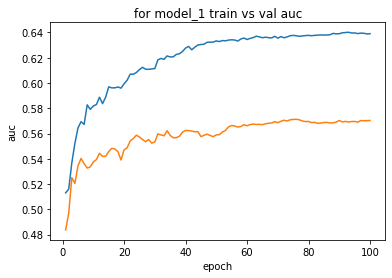

In [ ]:
train_auc=history_own_model.history['train_auc']
val_auc=history_own_model.history['val_auc']
import matplotlib.pyplot as plt
plt.title("for model_1 train vs val auc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("auc")
plt.plot(range(1,101),train_auc)
plt.plot(range(1,101),val_auc)

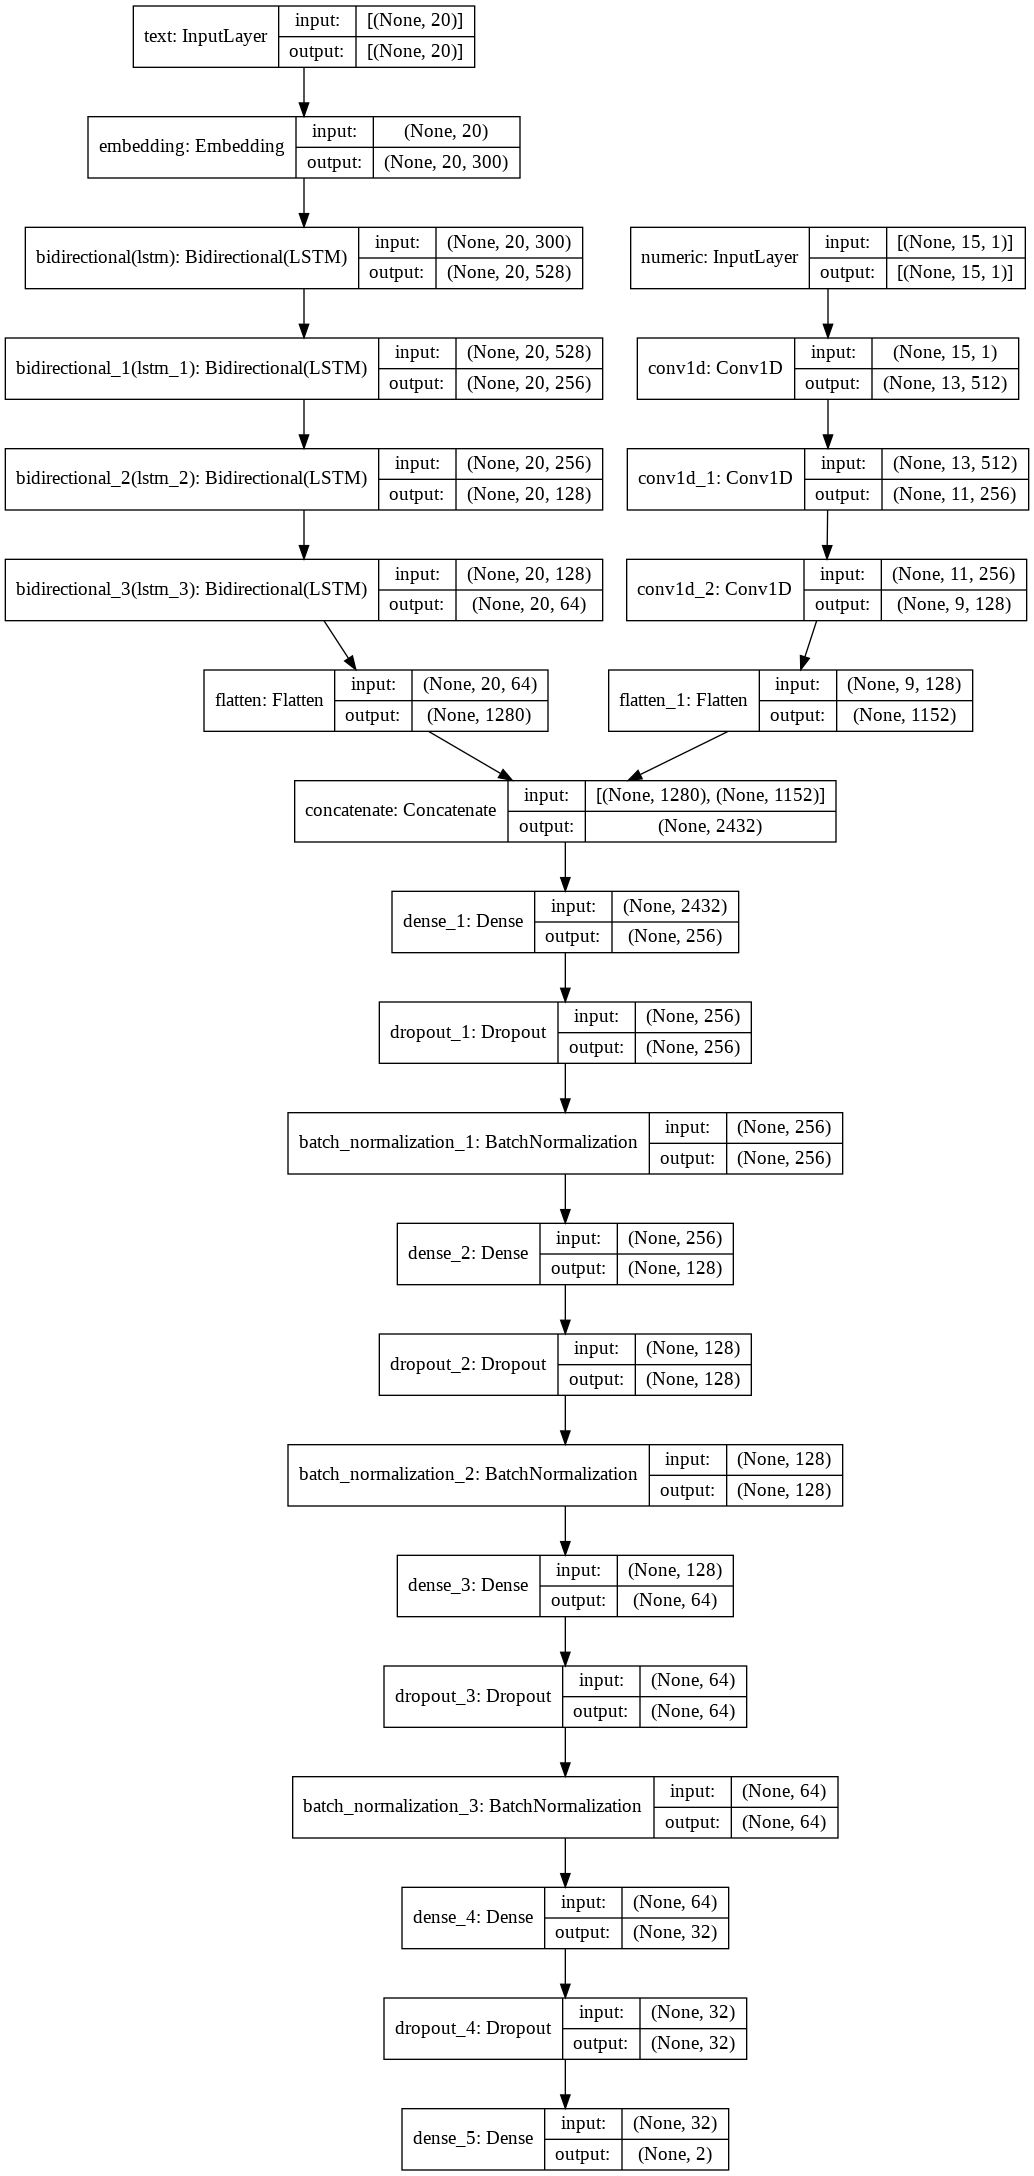

In [ ]:
tensorflow.keras.utils.plot_model(lstm_model, "lstm_model.png", show_shapes=True)